# Stock Deep Recurrent Q-Network 
This notebook provides an implementation of a Deep Double Recurrent Q-Network which can solve Partially Observable Markov Decision Processes. This notebook applies the technique on time series.

In [1]:
import numpy as np
import math
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
import os
import csv
import itertools
%matplotlib inline
import time
from sklearn.preprocessing import MinMaxScaler
from helper import *
from StockEnv import StockEnv
import pandas as pd
from GeometricBrownianMotion import * 
from MCSAmericanOptionPricing import *

seed = 1#time.time()
random.seed(seed)
print('Seed is:' + str(seed))

Seed is:1


### Variable settings

In [1]:
risk_free_rate = 5/100
sigma = 0.20
num_seeds = 60

In [3]:
save_model_freq = 10000 #5000
Normalization = False
Window_Normalization = False #True #False
test_data_ratio = 0.2 #0.3 # 0.2

architecture = 0 #3 #0 #1 #2 #3 #4 #5
nbFilters = 32 #16 #1
paddingType = 'same' #'causal' # 'valid'
huber_loss = False #True #False
dueling_type = 'avg' #'max' 'naive'
mask_type = 'default' #'maskFirstHalf' # 'maskByWeights' 'default'
apply_dropout = False
batch_size = 32 #16 #32 #128 #60 #20 #4 #How many experience traces to use for each training step.
memory_capacity = 3000 #1000
learning_rate = 0.0025 #0.01 0.025 0.0025 0.0001
apply_grad_clipping = True
grad_clipping = 5 # Maybe test with bigger values, e.g. 40 or 30
optimizer_type = 'Adam' # 'GradientDescent' 'RMSProp'

Colab = False
scriptDirectory = os.getcwd() #"C:\Code_RL\2019_11_21_shuffled_GBM_version" #"C:\\Code_RL" # os.getcwd()

history_t = 15 #5 #15 #2 #15 ##
option_T = 50 #65 #50 #100 #365 #100 #200 #365 #65 #30 #15 #40 #30 ##
#build_warm_up_state_t = option_T // 3 #option_T // 2
input_size = history_t + 2
is_training = True

##hpq.us.txtmin date: 1970-01-02max date: 2017-11-10
min value of data: 8.53125, max value of data: 22.20295
train_size: 733
test_size: 183
##aapl.us.txtmin date: 1984-09-07max date: 2017-11-10
min value of data: 68.814, max value of data: 174.825
train_size: 733
test_size: 183
##goog.us.txtmin date: 2014-03-27max date: 2017-11-10
min value of data: 491.77, max value of data: 1035.9850000000001
train_size: 733
test_size: 183
##ibm.us.txtmin date: 1962-01-02max date: 2017-11-10
min value of data: 110.81, max value of data: 176.43
train_size: 733
test_size: 183
##ups.us.txtmin date: 1999-11-10max date: 2017-11-10
min value of data: 83.2025, max value of data: 119.64
train_size: 733
test_size: 183
##jnj.us.txtmin date: 1970-01-02max date: 2017-11-10
min value of data: 83.78399999999999, max value of data: 143.231
train_size: 733
test_size: 183
##msft.us.txtmin date: 1986-03-13max date: 2017-11-10
min value of data: 35.632999999999996, max value of data: 84.905
train_size: 733
test_size: 1

min value of data: 41.0685, max value of data: 96.575
train_size: 733
test_size: 183
##hon.us.txtmin date: 1970-01-02max date: 2017-11-10
min value of data: 79.153, max value of data: 147.02499999999998
train_size: 733
test_size: 183


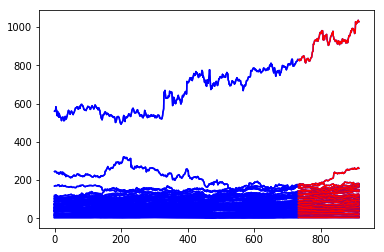

In [4]:
stock_names = ['hpq.us.txt', 'aapl.us.txt', 'goog.us.txt', 'ibm.us.txt', 'ups.us.txt',
              'jnj.us.txt', 'msft.us.txt', 'pg.us.txt', 'tsn.us.txt', 'usa.us.txt',
              'tex.us.txt', 'sam.us.txt', 'salt.us.txt', 'tlys.us.txt', 'trq.us.txt',
              'trno.us.txt', 'trk.us.txt', 'tnp.us.txt', 'tjx.us.txt', 'tpx.us.txt',
              'fb.us.txt', 'jpm.us.txt', 'v.us.txt', 'bac.us.txt',
               'ma.us.txt', 'hd.us.txt', 'tsm.us.txt', 'dis.us.txt',
               'intc.us.txt', 'vz.us.txt', 'rds-b.us.txt', 'tm.us.txt',
               'cvx.us.txt','wfc.us.txt', 'nvs.us.txt', 'ko.us.txt',
              'mrk.us.txt', 'ba.us.txt', 'pfe.us.txt', 'cmcsa.us.txt',
               'sap.us.txt', 'chl.us.txt', 'ul.us.txt', 'bud.us.txt',
               'un.us.txt','wfc.us.txt', 'mdt.us.txt', 'hsbc.us.txt',
              'mcd.us.txt', 'nke.us.txt', 'adbe.us.txt', 'crm.us.txt',
               'tot.us.txt', 'ptr.us.txt', 'cost.us.txt', 'bp.us.txt',
               'pm.us.txt', 'amgn.us.txt', 'abbv.us.txt', 'hon.us.txt']
stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_name in stock_names:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='r')

### Load the game environment

Setting our environment

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 1252
num_episodes_per_epoch: 40080
min value of stock: 79.153, max value of stock: 123.065


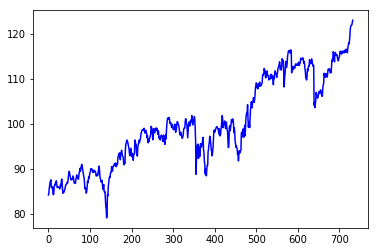

In [6]:
#env = StockEnv(train_data, risk_free_rate, history_t=history_t, option_T=option_T)
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
build_warm_up_state_t = env.get_build_warm_up_state()
trace_length = option_T - build_warm_up_state_t
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

# Select day of price over history bigger than option price (B.M.) [Benchmark]

In [7]:
r = risk_free_rate #10/100
#n = 400
isRiskNeutral = False
num_episodes = env.get_total_num_episodes_per_epoch() #max_num_observations - option_T
max_epLength = option_T
summaryLength = 100 #Number of epidoes to periodically save for analysis
summaryAverageReward = 5000

In [8]:
begin_time = time.time()

test = 'BM' #'Random'

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0

        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MinValue' or test == 'Normal' or test == 'BM':
          sell_time = -1

        while j < max_epLength: 
            if test == 'MinValue':
              if env.get_time() >= build_warm_up_state_t and (s[-1] <= min(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'BM':
              #if j == sell_time and env.get_payoff() > 0:
              T_BM, S0_BM, k_BM, mu_BM, sigma_BM, n_BM = env.getParameters()
              if env.get_time() >= build_warm_up_state_t and env.get_payoff() > 0 and (env.binomialTreeExercise
                (T_BM, S0_BM, k_BM, risk_free_rate, mu_BM, sigma_BM, n_BM, isRiskNeutral)[1] == True or j == max_epLength - 1):
                a = 1
              else:
                a = 0

            s1P,r,d = env.step(a)

            s1 = processState(s1P, input_size)

            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option

            if env.is_episode_finished():
                break

        #myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()

        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR)
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))

option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.03322325649202999	16.78
episode 200: 	0.02292011366344279	16.08
episode 300: 	0.028885393470018565	16.13
episode 400: 	0.023621532720936648	12.92
episode 500: 	0.02694520145371603	14.46
episode 600: 	0.03560768752013241	14.38
episode 700: 	0.026438517333165882	16.96
episode 800: 	0.03277417111774436	16.2
episode 900: 	0.03306922727514297	15.36
episode 1000: 	0.019236646022655773	14.5
episode 1100: 	0.04469566210104596	17.99
episode 1200: 	0.01915672380150062	13.53
episode 1300: 	0.024653895532779812	16.56
episode 1400: 	0.022465643753364448	13.38
episode 1500: 	0.024090889870107785	16.53
episode 1600: 	0.028622502054589948	14.32
episode 1700: 	0.027965321202139477	15.78
episode 1800: 	0.03608876518049327	16.84
episode 1900: 	0.03576141211890997	20.34
episode 2000: 	0.019777074612858703	13.76
episode 2100: 	0.024017748503854578	15.57
episode 2200: 	0.025244542461597918	14.78
episode 2300: 	0.032011685917294065	17.2
episode 2400: 	0.022892212542126304	15.59
episode 2500: 

episode 19300: 	0.02630235621801973	15.68
episode 19400: 	0.021238624580696433	14.51
episode 19500: 	0.02007788259899289	15.04
episode 19600: 	0.022334824814909185	15.15
episode 19700: 	0.025640890797436578	16.36
episode 19800: 	0.02235203021458928	14.11
episode 19900: 	0.028477131353720594	13.68
episode 20000: 	0.04400965330270219	20.05
#Average reward per episode 20000: 0.027165666326545063
episode 20100: 	0.016541109819666854	14.34
episode 20200: 	0.02992217136251015	14.21
episode 20300: 	0.027244089932146557	16.08
episode 20400: 	0.030144759145183865	16.49
episode 20500: 	0.032160626142625624	14.7
episode 20600: 	0.023328662607344838	14.16
episode 20700: 	0.02404081561571144	15.11
episode 20800: 	0.0314105830482745	15.04
episode 20900: 	0.0203303889678835	14.26
episode 21000: 	0.0274410039519007	15.6
episode 21100: 	0.029322178046187742	16.12
episode 21200: 	0.04286278893714101	15.6
episode 21300: 	0.022500554148377594	12.2
episode 21400: 	0.023408536659983145	13.13
episode 21500: 

episode 38100: 	0.020887888106121296	13.63
episode 38200: 	0.021365390627321488	13.07
episode 38300: 	0.026470612317542018	16.29
episode 38400: 	0.031279147055426094	17.18
episode 38500: 	0.026341661894655713	14.95
episode 38600: 	0.027549314212295832	14.46
episode 38700: 	0.026306276354256215	17.19
episode 38800: 	0.02221741909794761	13.9
episode 38900: 	0.02703639652856335	15.88
episode 39000: 	0.02319905640913836	13.48
episode 39100: 	0.028552496537846084	16.59
episode 39200: 	0.028138666575637176	13.26
episode 39300: 	0.02526037899311643	13.04
episode 39400: 	0.02615077958487244	16.05
episode 39500: 	0.026335025064177568	17.42
episode 39600: 	0.02156396466047564	16.15
episode 39700: 	0.03360917183737382	17.53
episode 39800: 	0.02384575530739934	13.35
episode 39900: 	0.03371393602305257	16.02
episode 40000: 	0.02942725974100372	13.82
#Average reward per episode 40000: 0.02727912160482129
#Total average reward per episode: 0.027280692199345986
#Max possible average reward per episode

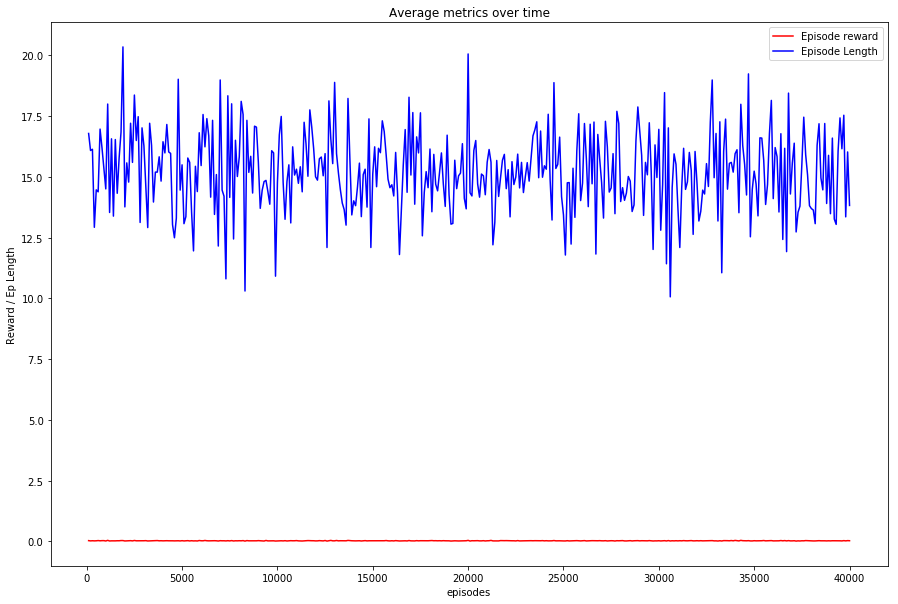

In [9]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

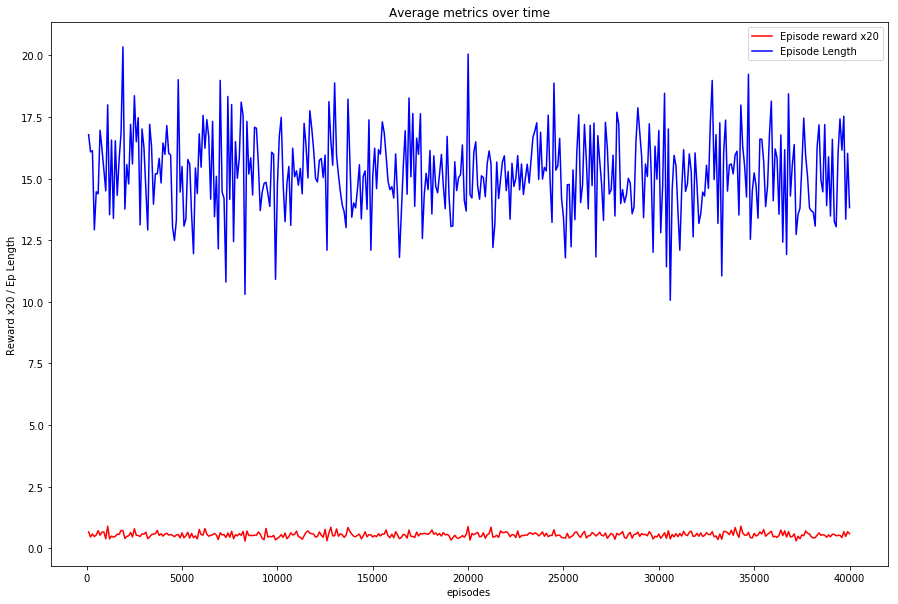

In [10]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

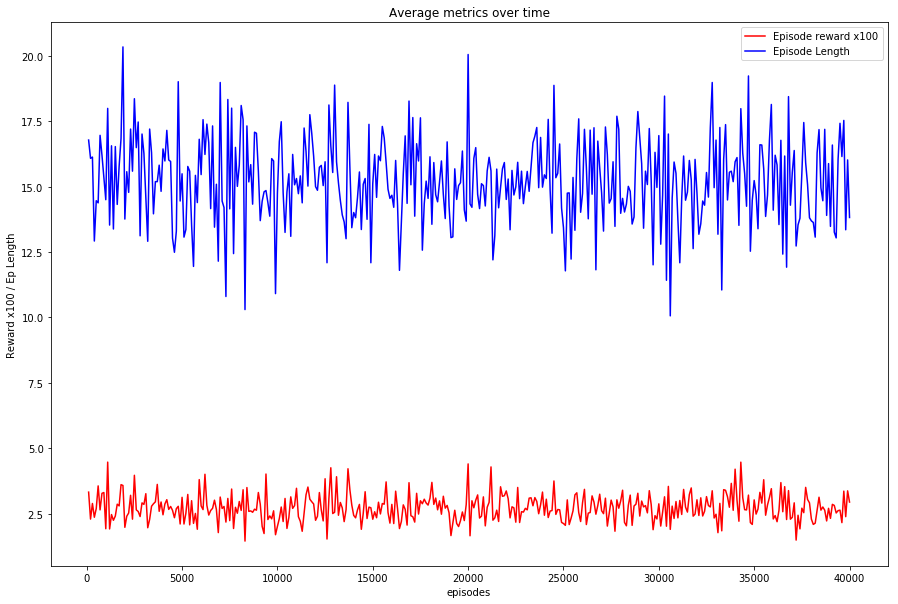

In [11]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

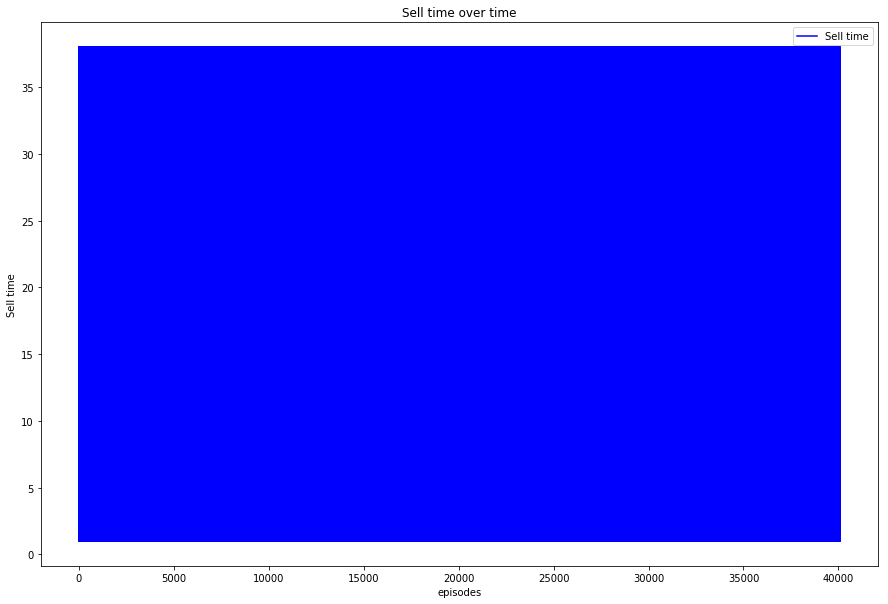

In [12]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

### Experience Replay

These classes allow us to store experies and sample then randomly to train the network.
Episode buffer stores experiences for each individal episode.
Experience buffer stores entire episodes of experience, and sample() allows us to get training batches needed from the network.

In [13]:
class experience_buffer():
    def __init__(self, buffer_size = memory_capacity, build_warm_up_state_t=build_warm_up_state_t):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size] = []
        self.buffer.append(experience)
    
    def sample(self,batch_size):
        sampled_episodes = random.sample(self.buffer,batch_size)
        #sampled_episodes = np.array(sampled_episodes)
        sampled_episodes = self.processEpisodes(sampled_episodes)
        return np.reshape(sampled_episodes,[-1,5])
    
    def processEpisodes(self,sampled_episodes):
        sampledTraces = []
        for episode in sampled_episodes:
            sampledTraces.append(episode[build_warm_up_state_t:])
        sampledTraces = np.array(sampledTraces)
        return sampledTraces

### Training the network

In [14]:
#Setting the training parameters
num_layers = 1 #2 #3 # Number of layer of LSTM
h_size = 512 #256 #512 #128 #512 #256 #512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
keep_prob = 0.8
dropout = 1 - keep_prob  # dropout amount
update_freq = 5 #30 #10 #5 #How often to perform a training step.
update_online_freq = 5 #10 #5 #3 #5
update_target_freq = 30
gamma = env.get_discount_factor(1) # discount for 1 day
startE = 1 #0.1 #1 #Starting chance of random action
endE = 0.1 #0.01 #0.1 #Final chance of random action
num_episodes = env.get_total_num_episodes_per_epoch()*5 #30 #50000 #20000 #100000 #20000 #3000 #20000 #30000 #10000 #4000 #100000 #40000
pre_train_episodes = int(memory_capacity * 0.1) # 0.25 300 #300 #200 #600 #200
annealing_episodes = int(num_episodes * 0.3) #4*memory_capacity #0.7*memory_capacity #400 #memory_capacity #400
pre_exploitation_episodes = int(num_episodes * 0.6)
annealing_exploitation_episodes = int(num_episodes * 0.25)
exploitationE =  0.01 #0.008 #0.02
load_model = False #Whether to load a saved model.
path = os.path.join(scriptDirectory, 'savedModel') #The path to save our model to.
max_epLength = option_T #env.get_max_episode_time() #option_T + build_warm_up_state_t
summaryLength = 100 #Number of epidoes to periodically save for analysis
summaryAverageReward = 5000
tau = 0.001 # learning rate (also referred to as step size) for target network
softUpdate = False # use soft or hard updates
trained_model_name = os.path.join(path, 'architecture' + str(architecture) + '-option_T' + str(option_T) + '-history_t' + str(history_t) + '-num_episodes' + str(num_episodes) + '-tau' + str(tau) + '-softUpdate' + str(softUpdate) + '-dropout' + str(dropout) + '-mask' + str(mask_type) + '-dueling_type' + str(dueling_type))
final_trained_model_name = trained_model_name + '-final'
exploration_type = 'Random'
print('#num_episodes: ' + str(num_episodes))
print('#trace_length: ' + str(trace_length))
print('#gamma: ' + str(gamma))

#num_episodes: 200400
#trace_length: 38
#gamma: 0.9998016069840849


### Testing the network

In [15]:
load_model = True #Whether to load a saved model.
is_training = False

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 221
num_episodes_per_epoch: 7080
min value of stock: 121.705, max value of stock: 147.02499999999998


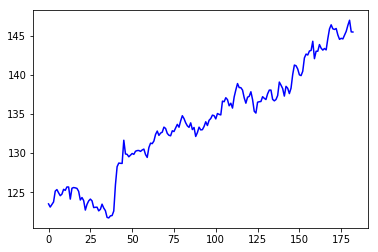

In [16]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

# Select day of price over history bigger than option price (B.M.) [Benchmark]

In [17]:
r = risk_free_rate

In [18]:
begin_time = time.time()

test = 'BM' #'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MinValue' or test == 'Normal' or test == 'BM':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MinValue':
              if env.get_time() >= build_warm_up_state_t and (s[-1] <= min(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'BM':
              #if j == sell_time and env.get_payoff() > 0:
              T_BM, S0_BM, k_BM, mu_BM, sigma_BM, n_BM = env.getParameters()
              if env.get_time() >= build_warm_up_state_t and env.get_payoff() > 0 and (env.binomialTreeExercise
                (T_BM, S0_BM, k_BM, risk_free_rate, mu_BM, sigma_BM, n_BM, isRiskNeutral)[1] == True or j == max_epLength - 1):
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break

        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]
                
print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.01003513112000761	9.57
episode 200: 	0.01353744591803708	10.53
episode 300: 	0.0128228602989418	11.4
episode 400: 	0.010521479469500567	9.64
episode 500: 	0.01490752551438026	10.16
episode 600: 	0.013648127723664215	10.37
episode 700: 	0.01365623275784056	9.37
episode 800: 	0.011462706657970176	9.22
episode 900: 	0.010699281171674601	11.76
episode 1000: 	0.012054128376472587	9.04
episode 1100: 	0.015223201765977776	10.38
episode 1200: 	0.013704133921193266	11.44
episode 1300: 	0.012595212505594316	10.47
episode 1400: 	0.013044326273891137	11.1
episode 1500: 	0.011772367913334194	10.96
episode 1600: 	0.01324016602317232	9.32
episode 1700: 	0.006931987103805808	6.29
episode 1800: 	0.009349052493480264	8.57
episode 1900: 	0.01434542645614143	11.4
episode 2000: 	0.01419879541754201	11.05
episode 2100: 	0.011568380841375674	12.25
episode 2200: 	0.010432491871529994	10.36
episode 2300: 	0.013562496784293467	9.6
episode 2400: 	0.010680337125791306	8.22
episode 2500: 	0.0123651

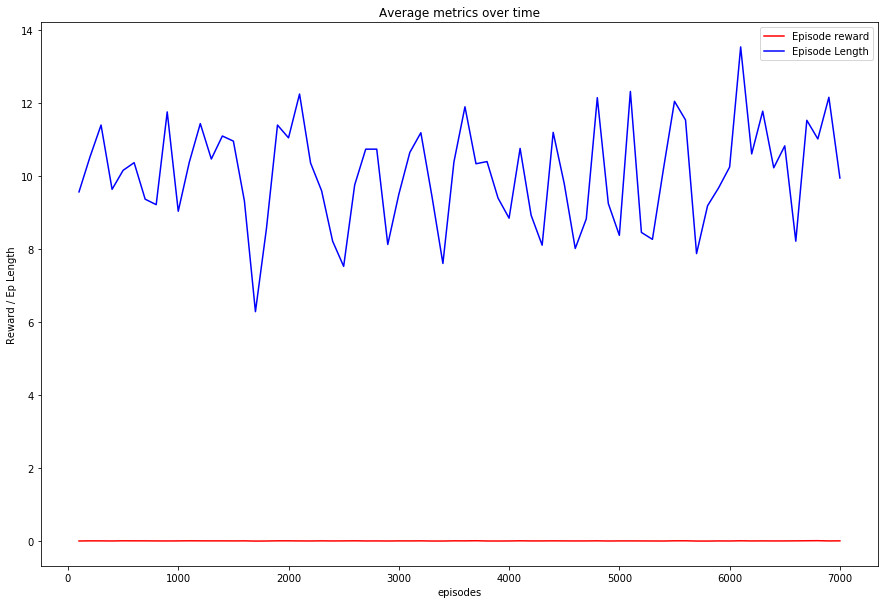

In [19]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

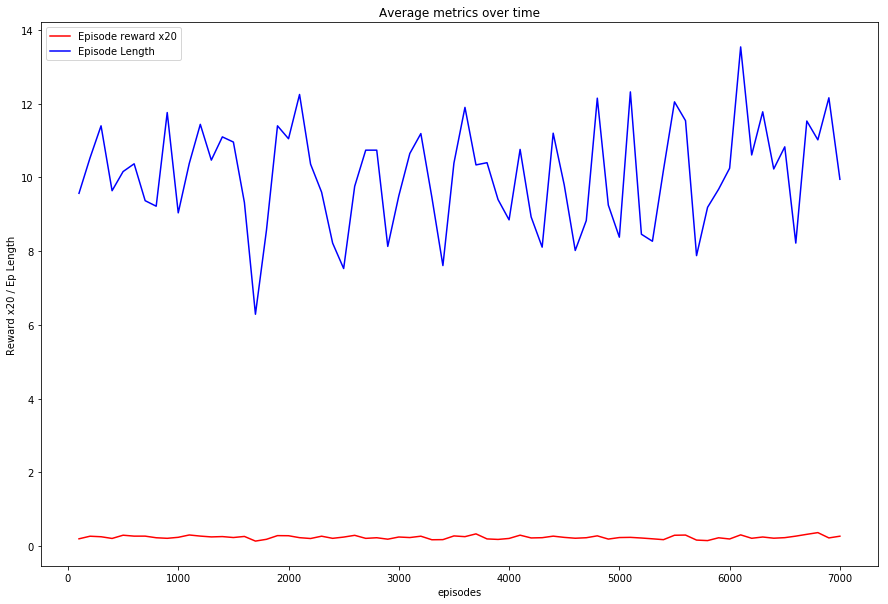

In [20]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

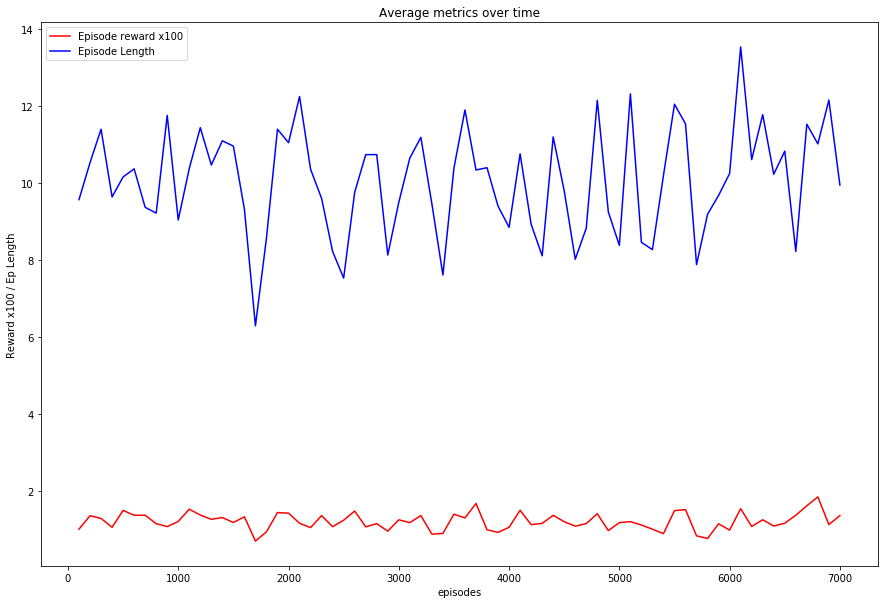

In [21]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

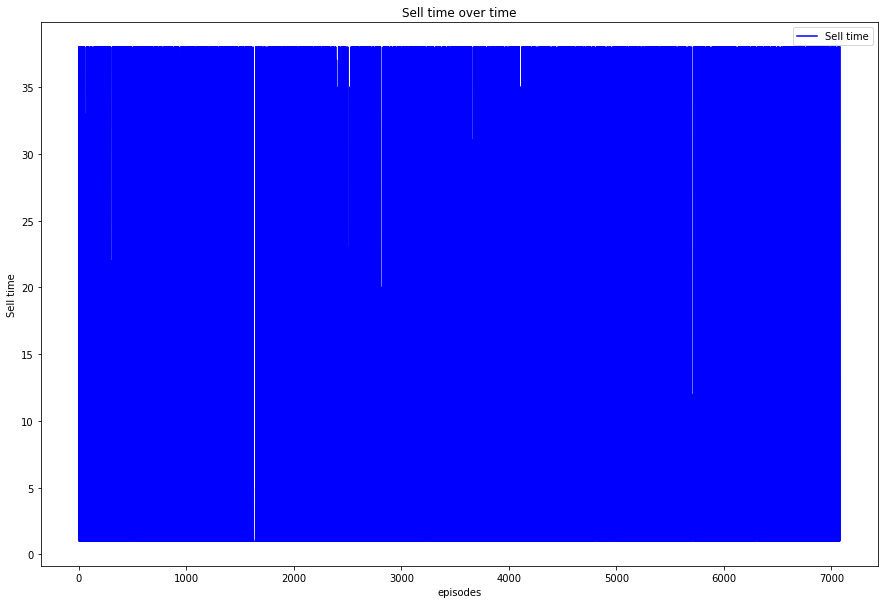

In [22]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

### Validation set

##t.us.txtmin date: 1984-07-19max date: 2017-11-10
min value of data: 27.646, max value of data: 40.954
train_size: 733
test_size: 183
##gm.us.txtmin date: 2010-11-17max date: 2017-11-10
min value of data: 24.1665, max value of data: 46.239999999999995
train_size: 733
test_size: 183
##cvs.us.txtmin date: 1984-12-17max date: 2017-11-10
min value of data: 68.035, max value of data: 107.81
train_size: 733
test_size: 183
##unh.us.txtmin date: 1990-03-26max date: 2017-11-10
min value of data: 70.606, max value of data: 212.865
train_size: 733
test_size: 183
##xom.us.txtmin date: 1970-01-02max date: 2017-11-10
min value of data: 63.616, max value of data: 91.847
train_size: 733
test_size: 183
##wmt.us.txtmin date: 1972-03-20max date: 2017-11-10
min value of data: 53.5275, max value of data: 90.945
train_size: 733
test_size: 183
##mck.us.txtmin date: 1994-11-15max date: 2017-11-10
min value of data: 121.72999999999999, max value of data: 238.81
train_size: 733
test_size: 183
##aat.us.txtmin d

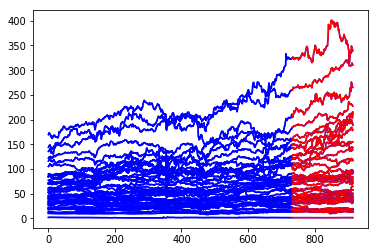

In [23]:
stock_names = ['t.us.txt', 'gm.us.txt', 'cvs.us.txt', 'unh.us.txt',
               'xom.us.txt', 'wmt.us.txt', 'mck.us.txt', # , 'brk-a.us.txt'
               'aat.us.txt', 'abc.us.txt', 'acre.us.txt', 'acta.us.txt',
               'fn.us.txt','fnb.us.txt', 'ford.us.txt', 'krg.us.txt',
              'pay.us.txt', 'peg.us.txt', 'tg.us.txt', 'tis.us.txt',
              'nflx.us.txt', 'acn.us.txt', 'utx.us.txt','lmt.us.txt',
              'nvda.us.txt', 'avgo.us.txt', 'azn.us.txt', 'tmo.us.txt',
               'unp.us.txt', 'lfc.us.txt', 'bhp.us.txt','sny.us.txt',
               'bbl.us.txt', 'ry.us.txt', 'asml.us.txt', 'nee.us.txt', 
              'txn.us.txt', 'gsk.us.txt', 'lly.us.txt', 'nvo.us.txt',
               'td.us.txt', 'qcom.us.txt', 'dhr.us.txt', 'chtr.us.txt',
               'sbux.us.txt', 'mmm.us.txt', 'axp.us.txt', 'hdb.us.txt',
              'csco.us.txt', 'orcl.us.txt', 'c.us.txt']
# unvalid stocks: 'kst.us.txt', 'ddt.us.txt', 'lgl.us.txt', 'aac.us.txt','adom.us.txt','acrs.us.txt', 'delt.us.txt', 'lcahu.us.txt', 'tpge.us.txt', 'wear.us.txt'

stocks_train_data = []
stocks_test_data = []
real_stocks_train_data = []
real_stocks_test_data = []
for stock_name in stock_names:
    #train_data, test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    train_data, test_data, real_train_data, real_test_data = prepare_company_stock(stock_name, Normalization, Window_Normalization, scriptDirectory, test_data_ratio)
    stocks_train_data.append(train_data)
    stocks_test_data.append(test_data)
    real_stocks_train_data.append(real_train_data)
    real_stocks_test_data.append(real_test_data)
    plt.plot(range(len(train_data)), train_data, color='b')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, color='r')

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 184
num_episodes_per_epoch: 5900
min value of stock: 56.837999999999994, max value of stock: 75.2365


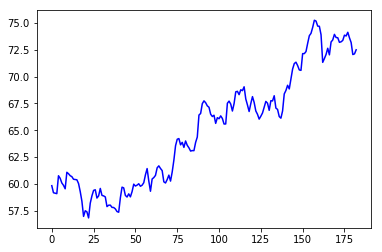

In [25]:
env = StockEnv(stocks_test_data, real_stocks_test_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(test_data)) + ', max value of stock: '+str(max(test_data)))
plt.plot(range(len(test_data)), test_data, color='b')

# Select day of price over history bigger than option price (B.M.) [Benchmark]

In [27]:
begin_time = time.time()

test = 'BM' #'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MinValue' or test == 'Normal' or test == 'BM':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MinValue':
              if env.get_time() >= build_warm_up_state_t and (s[-1] <= min(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'BM':
              #if j == sell_time and env.get_payoff() > 0:
              T_BM, S0_BM, k_BM, mu_BM, sigma_BM, n_BM = env.getParameters()
              if env.get_time() >= build_warm_up_state_t and env.get_payoff() > 0 and (env.binomialTreeExercise
                (T_BM, S0_BM, k_BM, risk_free_rate, mu_BM, sigma_BM, n_BM, isRiskNeutral)[1] == True or j == max_epLength - 1):
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break

        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.025136128144180446	12.56
episode 200: 	0.018016958130291114	10.25
episode 300: 	0.020977632049032496	11.59
episode 400: 	0.020421324735359	10.06
episode 500: 	0.01432826572278878	11.74
episode 600: 	0.011357385983339637	8.76
episode 700: 	0.024017794518187065	13.36
episode 800: 	0.014811870217701773	10.09
episode 900: 	0.0164073007027728	10.71
episode 1000: 	0.010497982829703123	9.48
episode 1100: 	0.015237803867940158	11.24
episode 1200: 	0.011988564029358235	10.47
episode 1300: 	0.022365965779755893	13.18
episode 1400: 	0.019426156317303142	11.66
episode 1500: 	0.00950381558115539	8.26
episode 1600: 	0.011963012194051952	9.56
episode 1700: 	0.016852839589440574	11.31
episode 1800: 	0.013684244999126237	10.74
episode 1900: 	0.01843209641403034	8.6
episode 2000: 	0.01791216526179863	12.85
episode 2100: 	0.01988982882811028	12.07
episode 2200: 	0.020890349521997687	11.26
episode 2300: 	0.009167768214143883	10.57
episode 2400: 	0.02023201136918456	12.5
episode 2500: 	0.02

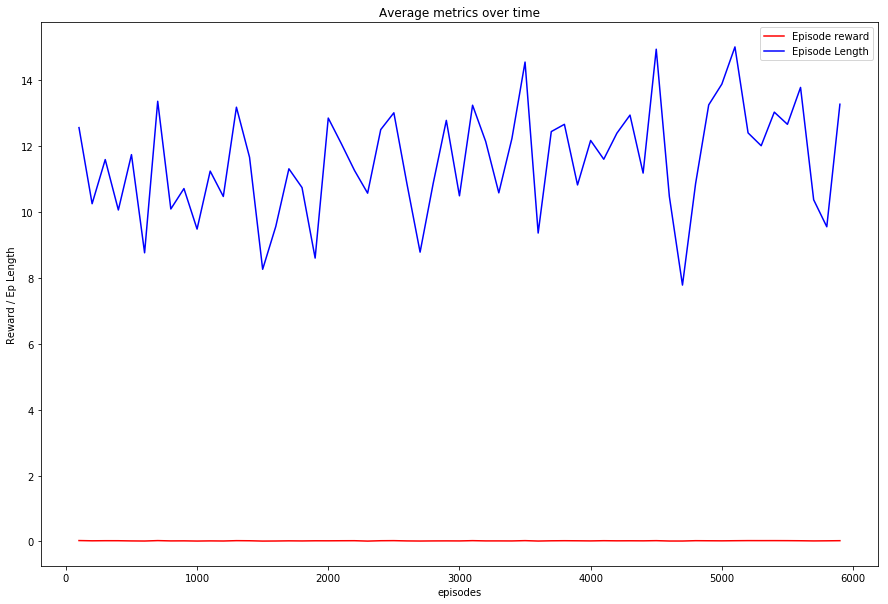

In [28]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

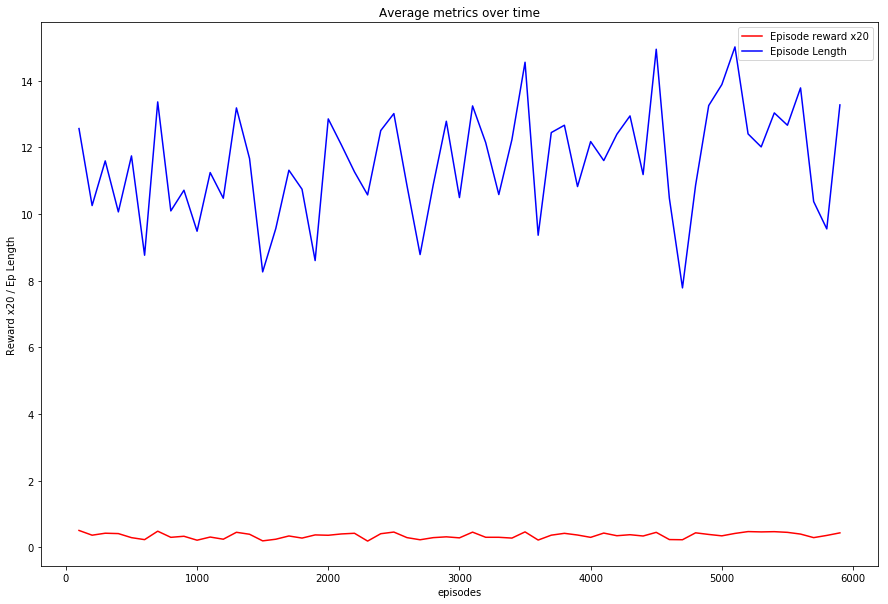

In [29]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

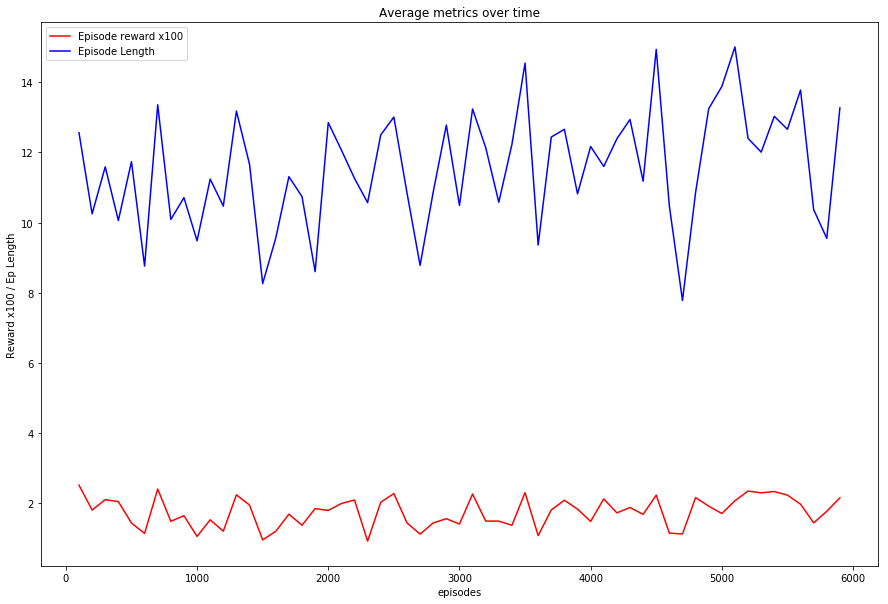

In [30]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

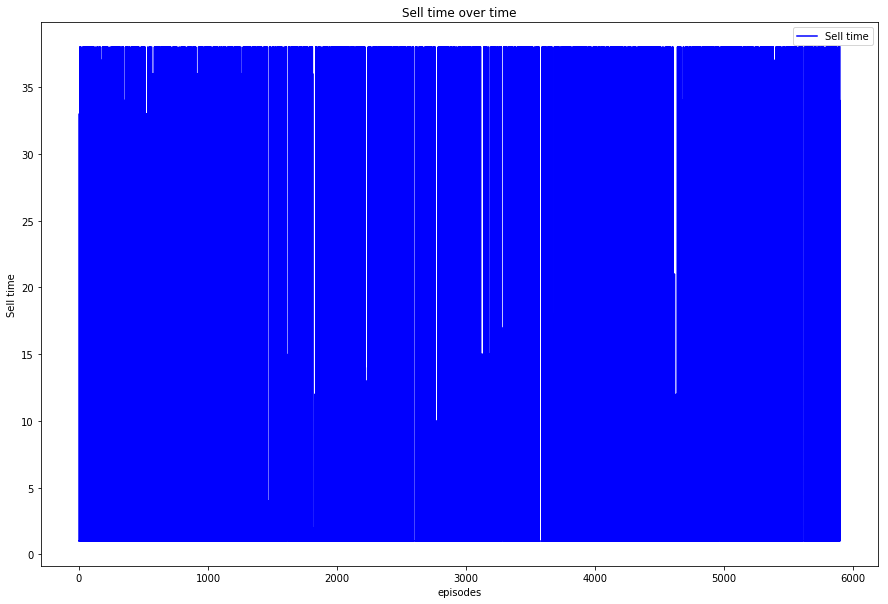

In [31]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Second Valid

###############################
option_T: 50
history_t: 15
build_warm_up_state_t: 12
###############################
num_batch_episodes_per_epoch: 1043
num_episodes_per_epoch: 33400
min value of stock: 34.557500000000005, max value of stock: 60.243500000000004


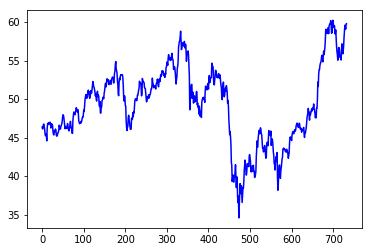

In [32]:
env = StockEnv(stocks_train_data, real_stocks_train_data, risk_free_rate, history_t=history_t, option_T=option_T)
#max_num_observations = env.max_num_observations
num_batch_episodes_per_epoch = env.get_total_num_episodes_per_epoch() // batch_size
num_episodes = env.get_total_num_episodes_per_epoch()
print('num_batch_episodes_per_epoch: ' + str(num_batch_episodes_per_epoch))
print('num_episodes_per_epoch: ' + str(env.get_total_num_episodes_per_epoch()))
print('min value of stock: '+str(min(train_data)) + ', max value of stock: '+str(max(train_data)))
plt.plot(range(len(train_data)), train_data, color='b')

# Select day of price over history bigger than option price (B.M.) [Benchmark]

In [34]:
begin_time = time.time()

test = 'BM' #'Random'

myBuffer = experience_buffer()

#create lists to contain total rewards and steps per episode
jList = []
rList = []
sTimeList = [] # sell time list

# Average metrics per 100 episodes
AvgEpisodeList = []
AvgrList = []
AvgsTimeList = []
maxPossiblerList = []

maxPossibleP_returnList = []
maxPossibleR_P_returnList = []

percentage_rList = []
real_percentage_rList = []

option_percentage_rList = []
option_real_percentage_rList = []

maxPossibleOptionP_returnList = []
maxPossibleOptionR_P_returnList = []
  

with tf.Session() as sess, tf.device('/gpu:0'):
    set_seed(seed)    
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP, input_size)
        d = False
        rAll = 0
        j = 0
        
        if test == 'Random':
          sell_time = random.randint(build_warm_up_state_t,max_epLength - 1)
        elif test == 'MinValue' or test == 'Normal' or test == 'BM':
          sell_time = -1
        
        while j < max_epLength: 
            if test == 'MinValue':
              if env.get_time() >= build_warm_up_state_t and (s[-1] <= min(s) or j == max_epLength - 1) and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'Random':
              if j == sell_time and env.get_payoff() > 0:
                a = 1
              else:
                a = 0
            elif test == 'BM':
              #if j == sell_time and env.get_payoff() > 0:
              T_BM, S0_BM, k_BM, mu_BM, sigma_BM, n_BM = env.getParameters()
              if env.get_time() >= build_warm_up_state_t and env.get_payoff() > 0 and (env.binomialTreeExercise
                (T_BM, S0_BM, k_BM, risk_free_rate, mu_BM, sigma_BM, n_BM, isRiskNeutral)[1] == True or j == max_epLength - 1):
                a = 1
              else:
                a = 0
                
            s1P,r,d = env.step(a)
            
            s1 = processState(s1P, input_size)
            
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) # store experience

            rAll += r
            s = s1
            sP = s1P
            j+=1 # episode length till selling or reaching last day of option
            
            if env.is_episode_finished():
                break

        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)
        sTimeList.append(env.get_sell_time() + 1)
        #maxPossiblerList.append(env.get_best_possible_reward())
        #best_reward, percentage_return, real_percentage_return = env.get_best_possible_reward()
        best_reward, stock_percentage_return, option_percentage_return, stock_real_percentage_return,\
        option_real_percentage_return = env.get_best_possible_reward()
        
        maxPossiblerList.append(best_reward)
        maxPossibleP_returnList.append(stock_percentage_return)
        maxPossibleR_P_returnList.append(stock_real_percentage_return)
        maxPossibleOptionP_returnList.append(option_percentage_return)
        maxPossibleOptionR_P_returnList.append(option_real_percentage_return)
        #real_percentage_rList.append(env.get_real_percentage_return())
        stock_percentage_return, option_percentage_return = env.get_percentage_return()
        percentage_rList.append(stock_percentage_return)
        option_percentage_rList.append(option_percentage_return)
        stock_percentage_return, option_percentage_return = env.get_real_percentage_return()
        real_percentage_rList.append(stock_percentage_return)
        option_real_percentage_rList.append(option_percentage_return)

        #Periodically print metrics. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            AvgR = np.mean(rList[-summaryLength:])
            AvgsT = np.mean(sTimeList[-summaryLength:])
            AvgEpisodeList.append(i+1)
            AvgrList.append(AvgR)
            AvgsTimeList.append(AvgsT)
            print('episode ' + str(i+1) + ': \t' + str(AvgR) 
                  + '\t' + str(AvgsT))
        if len(rList) % summaryAverageReward == 0 and len(rList) != 0:
            print ("#Average reward per episode " + str(i+1) + ": " + str(sum(rList)/len(rList)))
                
option_percentage_rList = [value for value in option_percentage_rList if not math.isnan(value)]
maxPossibleOptionP_returnList = [value for value in maxPossibleOptionP_returnList if not math.isnan(value)]

print ("#Total average reward per episode: " + str(sum(rList)/num_episodes))

print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList)))

print ("#Confidence Interval with prob of 90%: " + str(env.getConfidenceInterval(rList)))

print ("#Confidence Interval with prob of 95%: " + str(env.getConfidenceInterval95(rList)))

print ("#Sell time entropy: " + str(env.getEntropy(sTimeList)))

print ("#Percentage of stock returns (Normalized): " + str(np.mean(percentage_rList)))

print ("#Percentage of stock returns (Real values): " + str(np.mean(real_percentage_rList)))

print ("#Percentage of option returns (Normalized): " + str(np.mean(option_percentage_rList)))

print ("#Percentage of option returns (Real values): " + str(np.mean(option_real_percentage_rList)))

print ("#Max possible average stock percentage return per episode: " + str(np.mean(maxPossibleP_returnList)))

print ("#Max possible average real stock percentage return per episode: " + str(np.mean(maxPossibleR_P_returnList)))

print ("#Max possible average option percentage return per episode: " + str(np.mean(maxPossibleOptionP_returnList)))

print ("#Max possible average real option percentage return per episode: " + str(np.mean(maxPossibleOptionR_P_returnList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(real_percentage_rList)))

print ("#Confidence Interval of Percentage of returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 90%: " + str(env.getConfidenceInterval(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Normalized) with prob of 95%: " + str(env.getConfidenceInterval95(option_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 90%: " + str(env.getConfidenceInterval(option_real_percentage_rList)))

print ("#Confidence Interval of Percentage of option returns (Real values) with prob of 95%: " + str(env.getConfidenceInterval95(option_real_percentage_rList)))

#print ("#Discounted rewards:")

#print ("#Total average reward per episode: " + str(sum(rList)/num_episodes * discount_factor))

#print ("#Max possible average reward per episode: " + str(np.mean(maxPossiblerList) * discount_factor))

end_time = time.time()
print('#Time to execute: '+ str((end_time - begin_time)/60) + 'min')

episode 100: 	0.02916544112096799	15.74
episode 200: 	0.027992165282586395	17.28
episode 300: 	0.03308243396660824	16.35
episode 400: 	0.03269491446325411	14.21
episode 500: 	0.0429189542553955	18.1
episode 600: 	0.0309594663863587	16.46
episode 700: 	0.029273281549841566	15.1
episode 800: 	0.0332550882898001	17.07
episode 900: 	0.023958725490044602	15.49
episode 1000: 	0.029425528111050883	17.24
episode 1100: 	0.02975951647634862	19.05
episode 1200: 	0.031335805117401	14.8
episode 1300: 	0.025147701874272448	13.77
episode 1400: 	0.02946468780314434	16.01
episode 1500: 	0.02848601403868166	15.25
episode 1600: 	0.02043403489308533	13.71
episode 1700: 	0.025058939839910793	14.75
episode 1800: 	0.02911110700151019	16.11
episode 1900: 	0.0276199218676635	17.75
episode 2000: 	0.026794052857167506	14.68
episode 2100: 	0.015566744385034937	11.44
episode 2200: 	0.021596324123538038	15.34
episode 2300: 	0.02517607982238649	15.25
episode 2400: 	0.018557578661695058	14.2
episode 2500: 	0.02452648

episode 19400: 	0.02602325317165642	16.11
episode 19500: 	0.02654218892810037	15.55
episode 19600: 	0.024597081845334882	16.59
episode 19700: 	0.025975445460452294	17.3
episode 19800: 	0.030683279458887432	16.57
episode 19900: 	0.02785043841912033	14.49
episode 20000: 	0.030595132939788428	18.29
#Average reward per episode 20000: 0.02755467973176508
episode 20100: 	0.020431400672276886	14.13
episode 20200: 	0.0260069899772212	14.54
episode 20300: 	0.024062274312623123	13.39
episode 20400: 	0.023186927346645566	15.23
episode 20500: 	0.03260878637267584	16.1
episode 20600: 	0.026304549906508486	17.95
episode 20700: 	0.02925300244320166	16.12
episode 20800: 	0.029683532431202742	14.9
episode 20900: 	0.033053580465272576	16.74
episode 21000: 	0.03275514503569386	16.44
episode 21100: 	0.03383480063554901	16.18
episode 21200: 	0.027036332556234353	15.85
episode 21300: 	0.030600090373314667	13.13
episode 21400: 	0.02219362997827181	14.15
episode 21500: 	0.03125848937063791	15.18
episode 21600

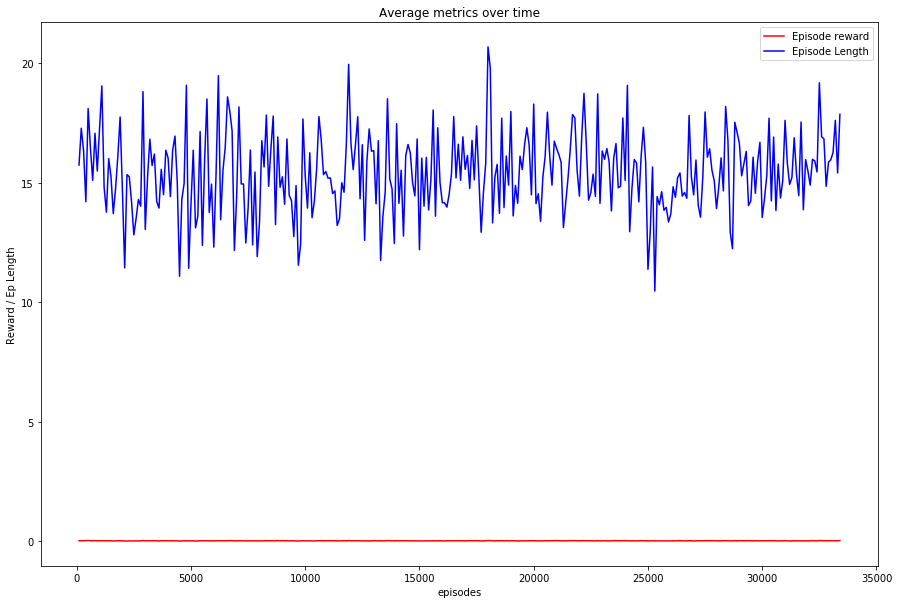

In [35]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, AvgrList, color='red', label='Episode reward')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward / Ep Length')
plt.legend(loc='best');

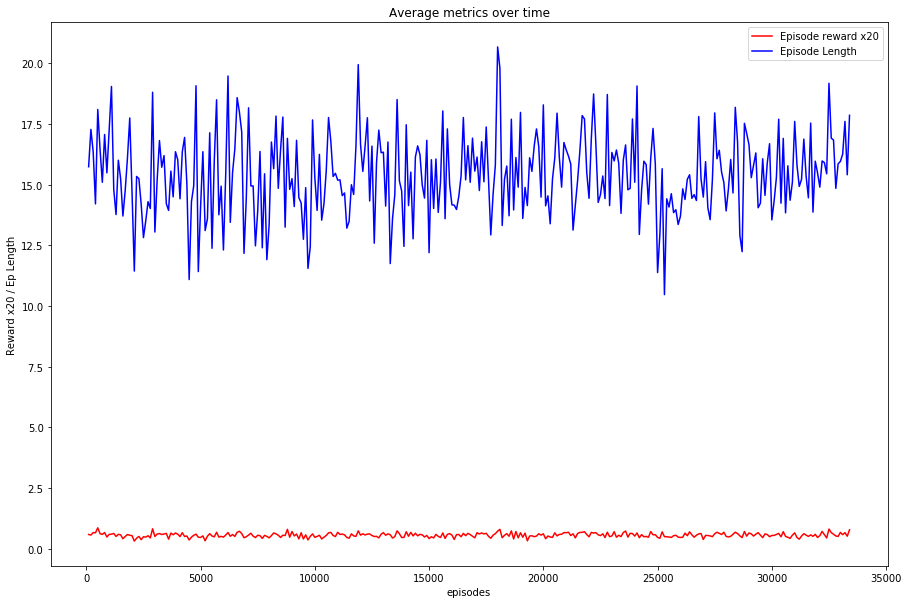

In [36]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*20, color='red', label='Episode reward x20')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x20 / Ep Length')
plt.legend(loc='best');

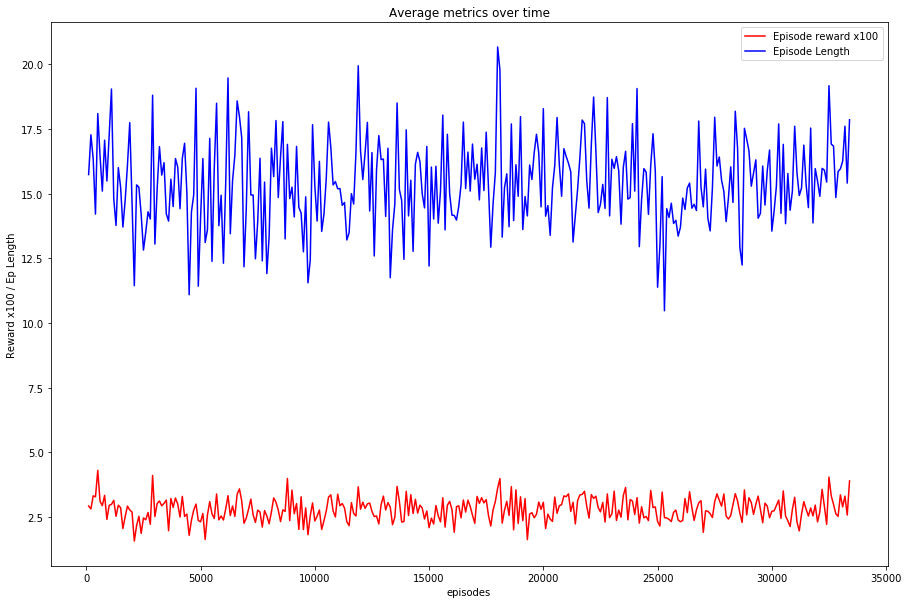

In [37]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(AvgEpisodeList, np.array(AvgrList)*100, color='red', label='Episode reward x100')
plt.plot(AvgEpisodeList, AvgsTimeList, color='blue', label='Episode Length')
plt.title('Average metrics over time')
plt.xlabel('episodes')
plt.ylabel('Reward x100 / Ep Length')
plt.legend(loc='best');

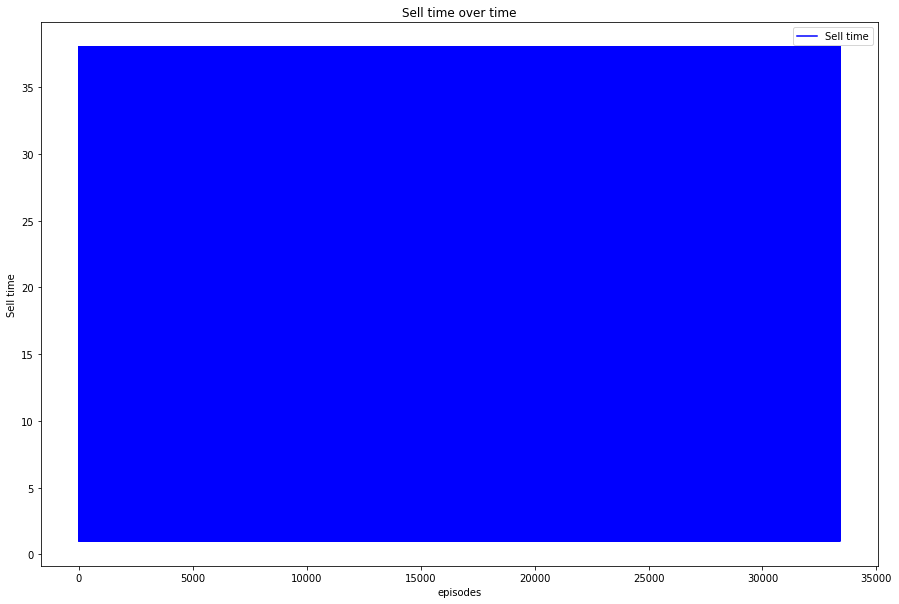

In [38]:
# show evolution of metrics over time
plt.figure(figsize=(15, 10));
plt.plot(range(len(sTimeList)), sTimeList, color='blue', label='Sell time')
plt.title('Sell time over time')
plt.xlabel('episodes')
plt.ylabel('Sell time')
plt.legend(loc='best');

# Print size of remaining objects

In [39]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
#sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
list_objects = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
#print(list_objects)
for x,y in list_objects:
    print(str(x)+": "+str(y))
    del x

jList: 285384
maxPossibleOptionP_returnList: 285384
maxPossibleOptionR_P_returnList: 285384
maxPossibleP_returnList: 285384
maxPossibleR_P_returnList: 285384
maxPossiblerList: 285384
option_percentage_rList: 285384
option_real_percentage_rList: 285384
percentage_rList: 285384
rList: 285384
real_percentage_rList: 285384
sTimeList: 285384
real_train_data: 5960
train_data: 5960
AvgEpisodeList: 2896
AvgrList: 2896
AvgsTimeList: 2896
StockEnv: 2000
real_test_data: 1560
test_data: 1560
AmericanOptionPricing: 1056
GBM: 1056
MinMaxScaler: 1056
experience_buffer: 1056
episodeBuffer: 528
real_stocks_test_data: 528
real_stocks_train_data: 528
stocks_test_data: 528
stocks_train_data: 528
stock_names: 464
final_trained_model_name: 285
trained_model_name: 279
s1P: 164
sP: 164
path: 143
build_data: 136
leaky_relu: 136
length: 136
normalize_data: 136
prepare_company_stock: 136
prepare_company_stock_yahoo: 136
prepare_data: 136
processState: 136
set_seed: 136
updateTarget: 136
updateTargetGraph: 136
sc